In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from scipy.fftpack import fft
import scipy
import seaborn as sns

import sklearn.linear_model as lm
import tensorflow as tf
import sklearn.svm as svm

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

import sklearn.preprocessing as pproc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import normalize
from imblearn.over_sampling import RandomOverSampler

/tmp/ipykernel_82411/729573235.py:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


## Getting the dataset
Also I randomized it since by default the data puts exoplanet stars on top.

In [3]:
training_data_pd = pd.read_csv('./data/exoTrain.csv')
test_data_pd = pd.read_csv('./data/exoTest.csv')
training_data = np.random.permutation(np.asarray(training_data_pd))
test_data = np.random.permutation(np.asarray(test_data_pd))

## Dataset proportions

In [4]:
num_exo = sum(i[0] == 2 for i in training_data)
num_no_exo = sum(i[0] == 1 for i in training_data)
num_exo/num_no_exo

0.007326732673267326

In [5]:
training_data_pd.head(5)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


## Seperating label and feature columns


In [6]:
data = {'train':{}, 'test': {}}
y1 = training_data[:,0]
y2 = test_data[:,0]
# Setting our labels to either 0 or 1
data['train']['labels'] = y1-1
data['test']['labels'] = y2-1

data['train']['features'] = np.delete(training_data,1,1)
data['test']['features'] = np.delete(test_data,1,1)


## Showing light curve

0.0


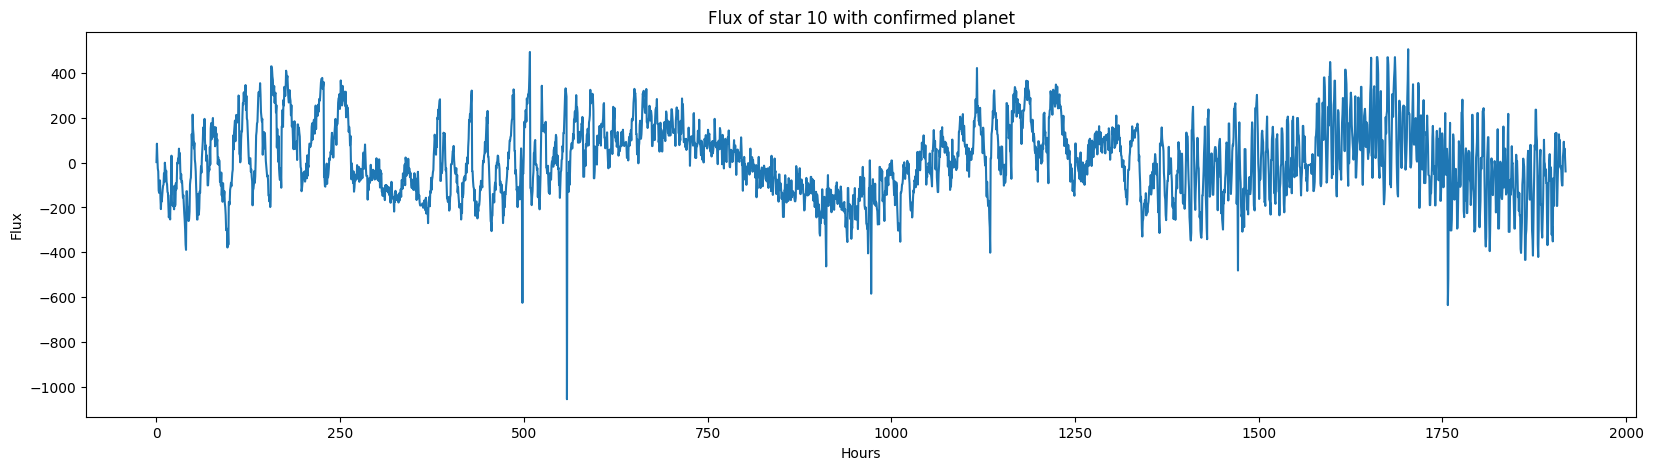

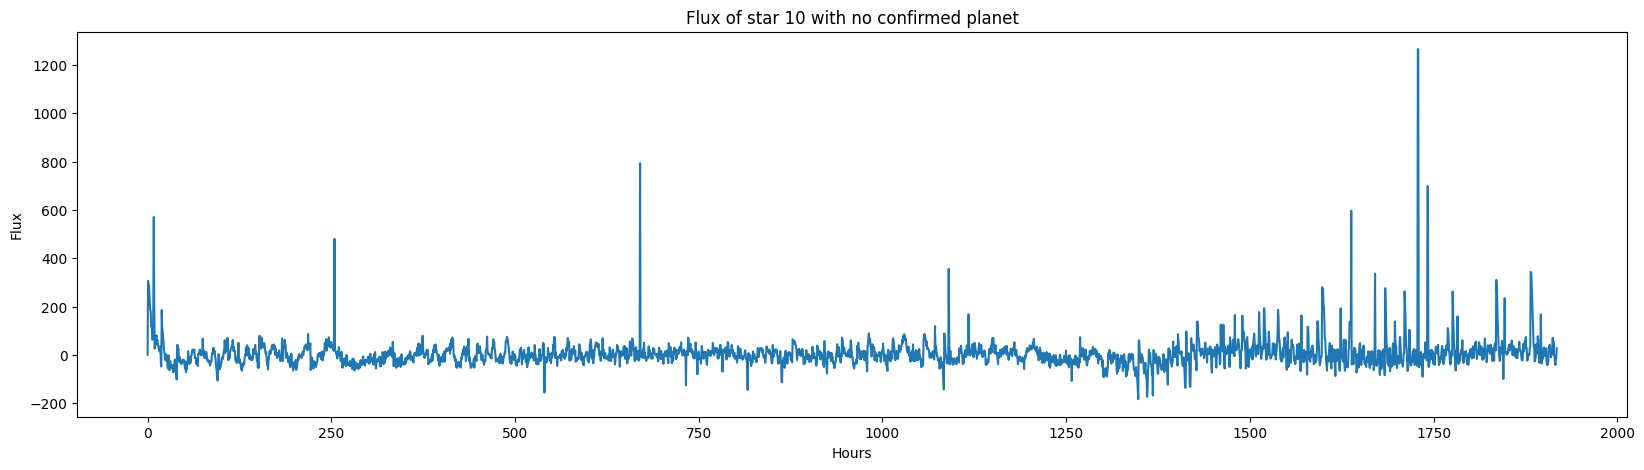

In [7]:
time = np.arange(len(data['train']['features'][0])) * (36/60)  # time in hours
all_data = np.delete(np.asarray(training_data_pd), 1, 1)
exoplanet_star = all_data[0]
not_exoplanet_star = all_data[-1]
# exoplpanet_flux_time_chart.png
plt.figure(figsize=(20,5))
plt.title('Flux of star 10 with confirmed planet')
plt.ylabel('Flux')
plt.xlabel('Hours')
plt.plot( time , exoplanet_star)

# exoplpanet_flux_time_chart.png
plt.figure(figsize=(20,5))
plt.title('Flux of star 10 with no confirmed planet')
plt.ylabel('Flux')
plt.xlabel('Hours')
plt.plot( time , not_exoplanet_star)
print(data['train']['labels'][10])

# Fixing data

## Normalizing the data

In [8]:
for x in data:
    data[x]['features'] = normalize(data[x]['features'])

In [9]:
data['train']['features']

array([[ 5.17413414e-04,  1.29715543e-02,  6.37453326e-03, ...,
         5.61393554e-03,  9.25135184e-03,  5.43284085e-03],
       [ 2.17674610e-03, -1.00696274e-01, -8.95731019e-02, ...,
        -1.51283854e-02, -3.91814297e-04,  4.57116680e-04],
       [ 1.15995907e-04, -1.73089093e-02, -1.44994884e-02, ...,
        -2.26482009e-02, -2.79294946e-02, -2.06577111e-02],
       ...,
       [ 3.70072037e-04, -1.30894480e-02, -5.83603603e-03, ...,
        -1.42736785e-02, -1.16387656e-02, -2.01393203e-02],
       [ 1.43507831e-03,  4.27653337e-03,  7.76377367e-03, ...,
        -1.02751607e-02,  2.23872217e-03,  1.43507831e-05],
       [ 3.34755418e-04, -8.84423815e-03, -4.39868620e-03, ...,
        -2.41793839e-02, -3.25281840e-02, -3.04593955e-02]])

## Applying Gaussian filter to the data

In [10]:
def gauss_filter(dataset,sigma):
    dts = []
    for x in range(dataset.shape[0]):
        dts.append(gaussian_filter(dataset[x], sigma))
    return np.asarray(dts)

In [11]:
data['train']['features'] = gauss_filter(data['train']['features'],7.0)
data['test']['features'] = gauss_filter(data['test']['features'],7.0)

0.0


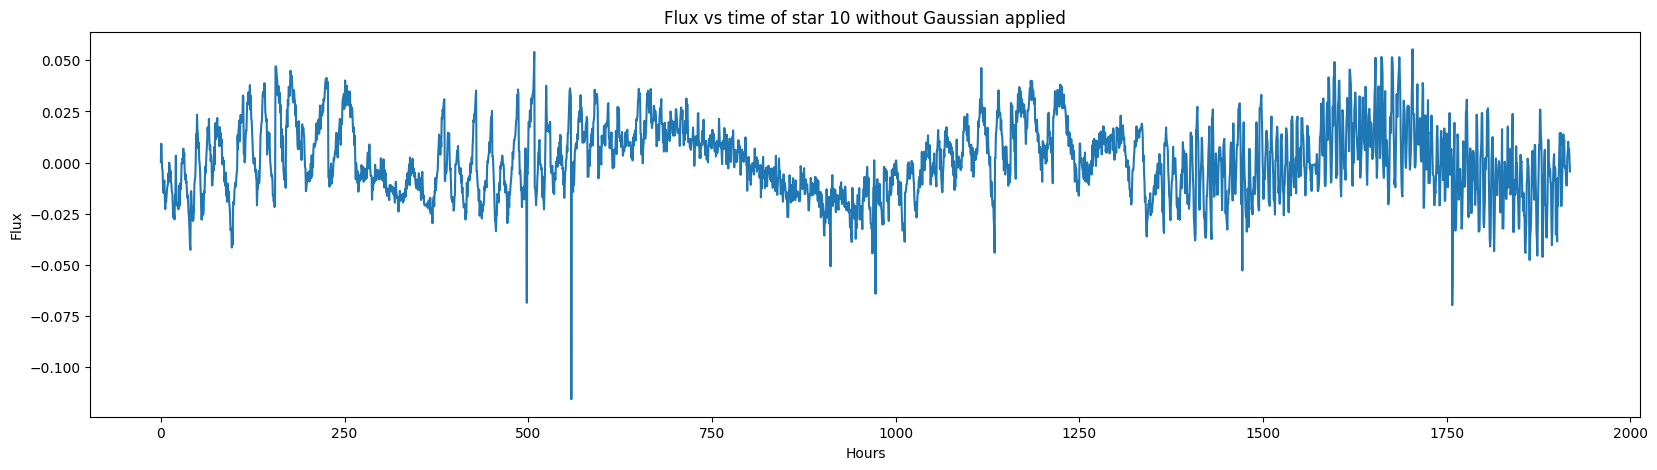

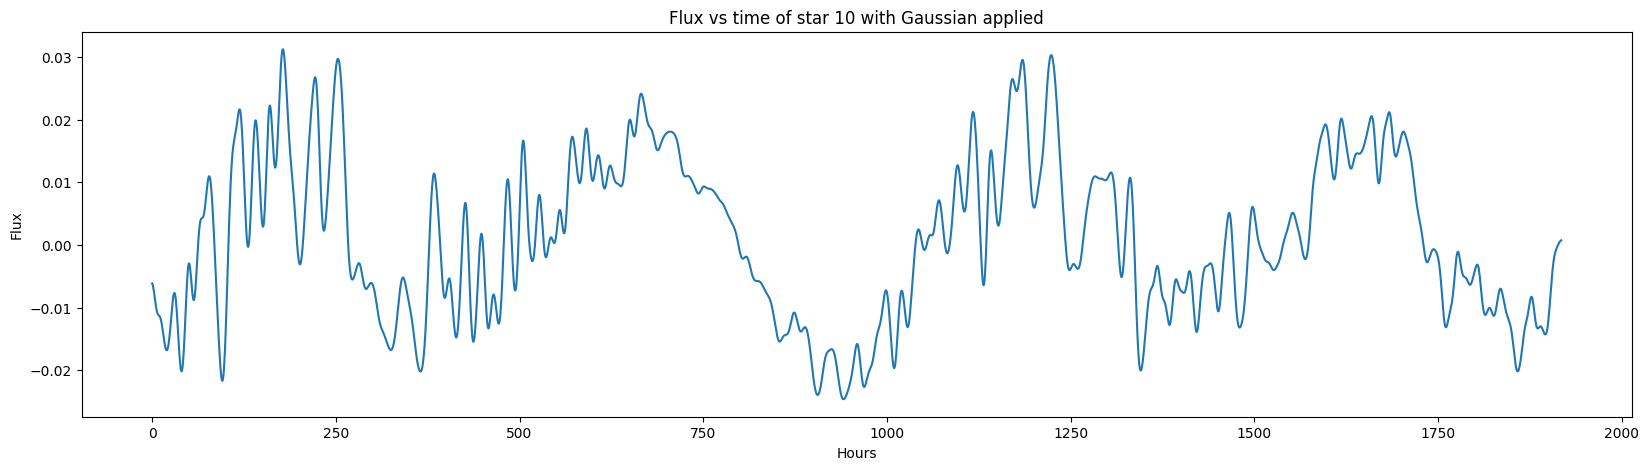

In [12]:
time = np.arange(len(data['train']['features'][0])) * (36/60)  # time in hours
all_data = np.delete(np.asarray(training_data_pd), 1, 1)
exoplanet_star = (gauss_filter(normalize(all_data), 7)[0])
not_exoplanet_star = normalize(all_data)[0]
# exoplpanet_flux_time_chart_no_gaussian.png
plt.figure(figsize=(20,5))
plt.title('Flux vs time of star 10 without Gaussian applied')
plt.ylabel('Flux')
plt.xlabel('Hours')
plt.plot( time , not_exoplanet_star)
print(data['train']['labels'][10])    
# exoplpanet_flux_time_chart_gaussian.png
plt.figure(figsize=(20,5))
plt.title('Flux vs time of star 10 with Gaussian applied')
plt.ylabel('Flux')
plt.xlabel('Hours')
plt.plot( time , exoplanet_star)

## Correcting proportions

In [13]:
rm = RandomOverSampler(sampling_strategy=0.5)
data['train']['features'], data['train']['labels'] = \
rm.fit_resample( data['train']['features'], data['train']['labels'])

In [14]:
num_exo = sum(i == 1 for i in data['train']['labels'])
num_no_exo = sum(i == 0 for i in data['train']['labels'])
num_exo/num_no_exo

0.5

# Model

In [15]:
amount_data = len(data['train']['features'][0])
print(amount_data)
model = tf.keras.Sequential([
    layers.Conv1D(filters=256, 
                  kernel_size=8, 
                  activation='relu', 
                  input_shape=(amount_data,1)
                  ),
    layers.MaxPool1D(strides=5),
    layers.BatchNormalization(),
    layers.Conv1D(filters=512,
                  kernel_size=6, 
                  activation='relu', 
                  input_shape=(amount_data,1)
                  ),
    layers.MaxPool1D(strides=5),
    layers.BatchNormalization(),
    layers.Conv1D(filters=256, 
                  kernel_size=4, 
                  activation='relu', 
                  input_shape=(amount_data,1)
                  ),
    layers.MaxPool1D(strides=5),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(24, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(12, activation='relu'),
    layers.Dense(8, activation = 'relu'),
    layers.Dense(1, activation='sigmoid')

])

3197


/home/rayan/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-26 20:45:55.864027: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-26 20:45:55.865048: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skippin

## Shaping the data to fit the model

In [16]:
for typ in data:
    data[typ]['features'] = np.asarray(data[typ]['features'])
    data[typ]['features'] = data[typ]['features'].reshape((data[typ]['features'].shape[0], data[typ]['features'].shape[1], 1))


In [17]:
print(f"Count 1: {sum(data['train']['labels'] == 1)}")
print(f"Count 0: {sum(data['train']['labels'] == 0)}")

Count 1: 2525
Count 0: 5050


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3190, 256)      │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 638, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 638, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 633, 512)       │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 127, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 127, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 124, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │       153,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,471,925 (5.61 MB)

 Trainable params: 1,469,877 (5.61 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [19]:
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              metrics=['accuracy'])

In [36]:
history = model.fit(data['train']['features'], 
                    data['train']['labels'] , 
                    epochs=3, 
                    batch_size = 10, 
                    validation_data=(data['test']['features'], 
                                     data['test']['labels']
                                     )
                    )

Epoch 1/3
758/758 ━━━━━━━━━━━━━━━━━━━━ 163s 215ms/step - accuracy: 0.9952 - loss: 0.0165 - val_accuracy: 0.9842 - val_loss: 0.2114
Epoch 2/3
758/758 ━━━━━━━━━━━━━━━━━━━━ 166s 219ms/step - accuracy: 0.9889 - loss: 0.0593 - val_accuracy: 0.9860 - val_loss: 0.1421
Epoch 3/3
758/758 ━━━━━━━━━━━━━━━━━━━━ 163s 214ms/step - accuracy: 0.9917 - loss: 0.0399 - val_accuracy: 0.9912 - val_loss: 0.1194


In [45]:
model.save('./model.keras')

In [28]:
model = models.load_model('./model.keras')

# Results

## Accuracy and loss

In [37]:
model.evaluate(
    x=data['test']['features'], 
    y=data['test']['labels'],
    batch_size = 10
    )

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9905 - loss: 0.1436


[0.11939822882413864, 0.9912280440330505]

## Precision

In [33]:
# Getting predicted values
all_data_labels = np.append(data['train']['labels'],data['test']['labels'],0)
all_data_features = np.append(data['train']['features'],data['test']['features'],0)
y_pred = model.predict(all_data_features)
y_pred = y_pred > 0.5

255/255 ━━━━━━━━━━━━━━━━━━━━ 54s 210ms/step


/tmp/ipykernel_82411/2031354668.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf_matrix = confusion_matrix([int(x) for x in all_data_labels ], [int(y) for y in y_pred ])


<Axes: >

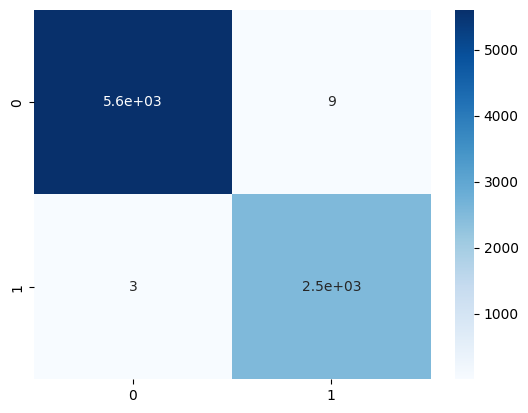

In [39]:
conf_matrix = confusion_matrix([int(x) for x in all_data_labels ], [int(y) for y in y_pred ])
# confmat.png
sns.heatmap(conf_matrix, annot=True, cmap='Blues')